In [3]:
import pandas as pd
from src.core.Processing import Processing
from src.core.Analyser import Analyser
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

In [4]:
file_path="/home/khaldi/Documents/data_app_machine/bank-additional-full.csv"
sep=";"
outcome="y"
positive_mod="yes"

In [5]:
df=pd.read_csv(file_path,sep=sep)

In [6]:
process=Processing() # object for df processing
analyzer=Analyser() #object which give graphics, statistics indicators for df

In [7]:
df.shape

(41188, 21)

In [8]:
process.summary(df)

{'Missing Values': age               0
 job               0
 marital           0
 education         0
 default           0
 housing           0
 loan              0
 contact           0
 month             0
 day_of_week       0
 duration          0
 campaign          0
 pdays             0
 previous          0
 poutcome          0
 emp.var.rate      0
 cons.price.idx    0
 cons.conf.idx     0
 euribor3m         0
 nr.employed       0
 y                 0
 dtype: int64,
 'Constant Features': []}

The dimension of the dataframe is (41188,21).
We can see that they don't have any missing values and constant features

no     0.887346
yes    0.112654
Name: y, dtype: float64

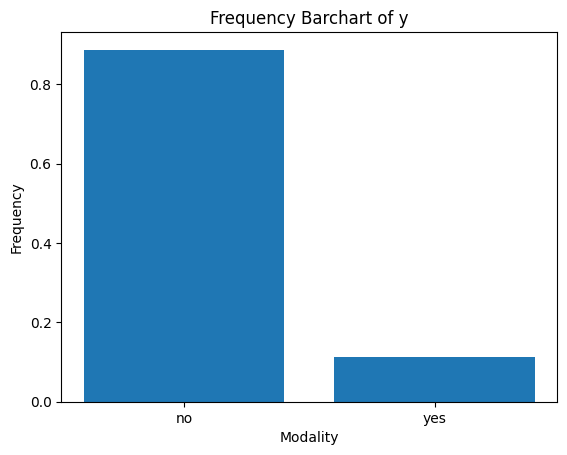

In [9]:
fig,ax=plt.subplots()
analyzer.bar_chart(df,outcome,ax,with_proportion=True)

We can see above that, Attrition attribute is imbalanced ( 36548 (~94%) rows for "no" modality and 4640 (~5.4%) for "yes" modality)

In [10]:
analyzer_summary=analyzer.summary(df)
quantitatives,qualitatives=analyzer_summary["features"]["quantitative_columns"],analyzer_summary["features"]["qualitative_columns"]

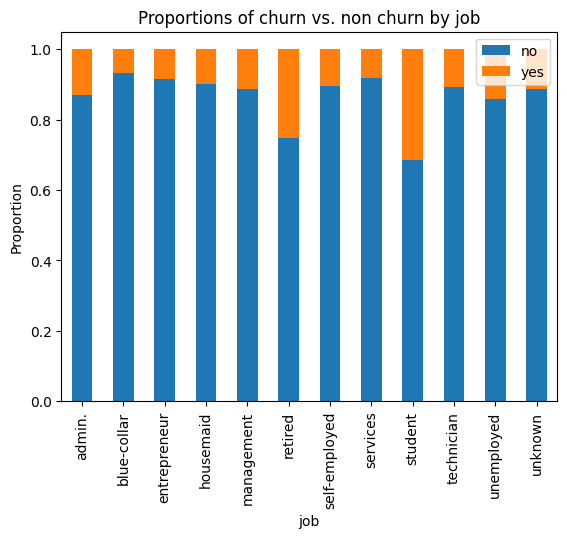

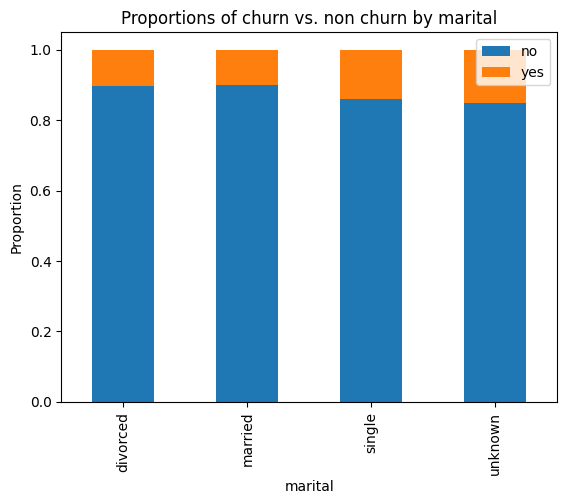

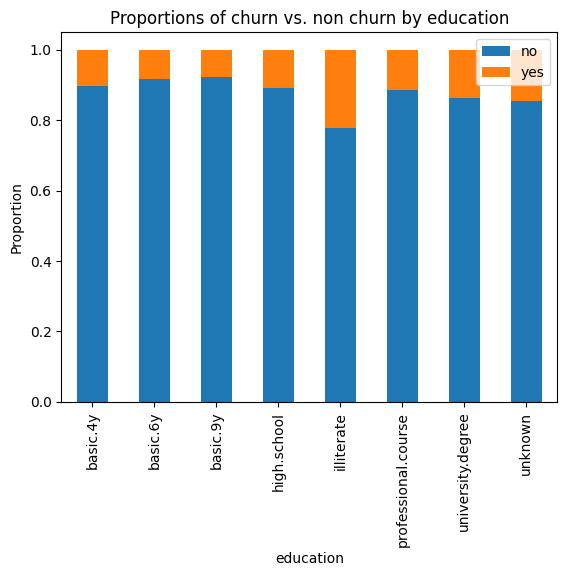

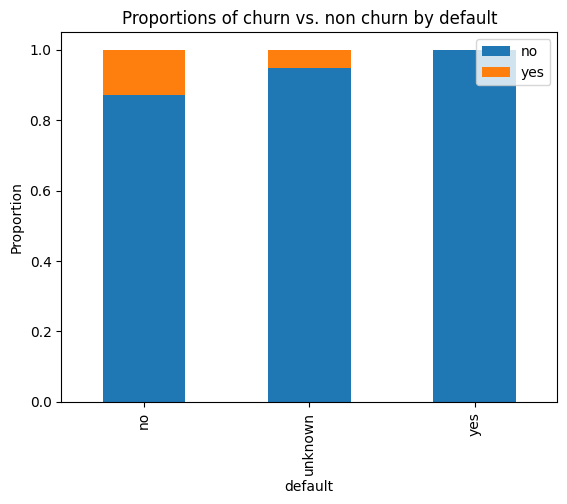

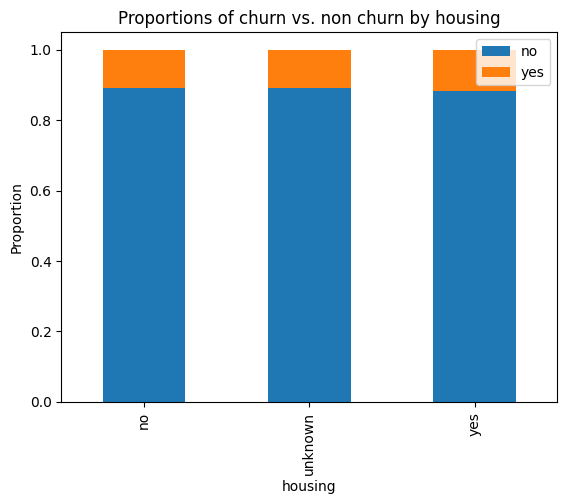

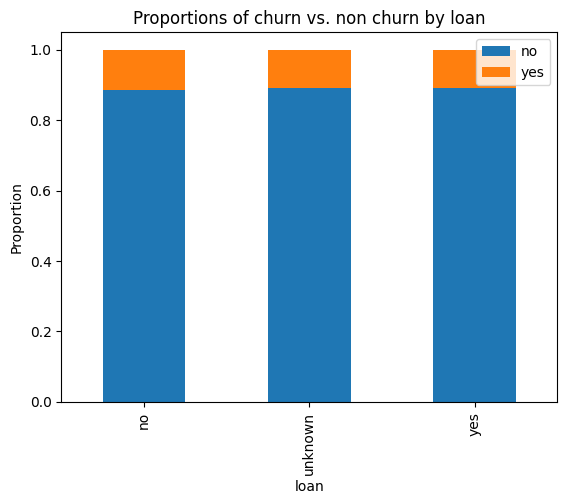

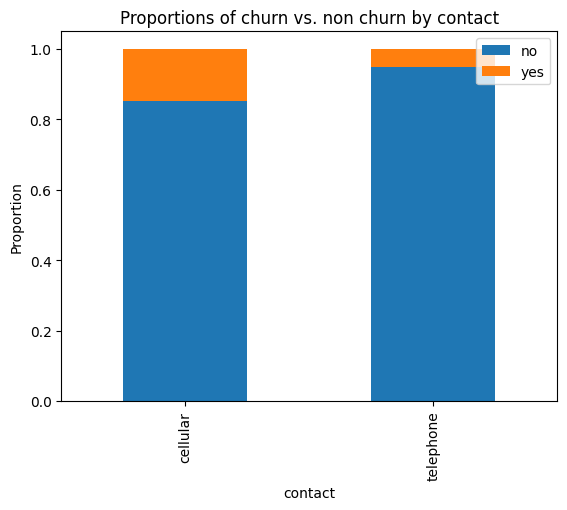

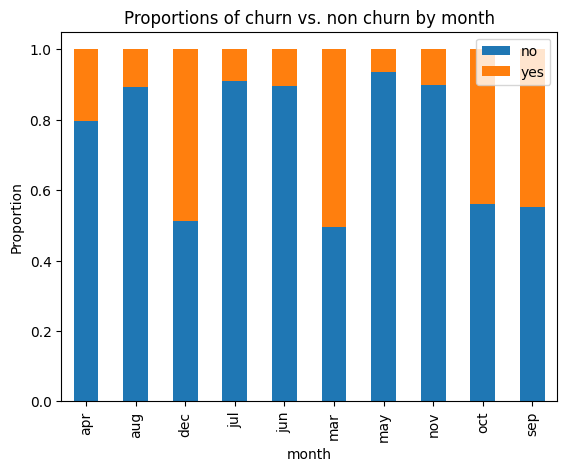

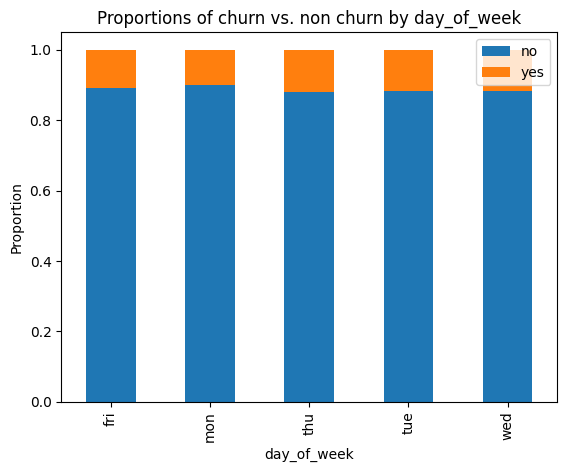

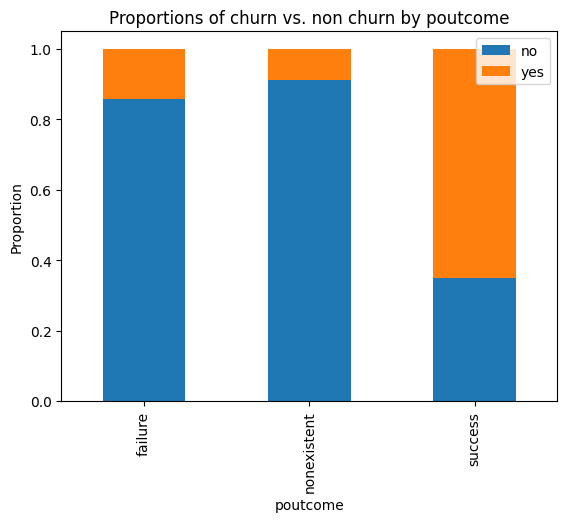

In [11]:
for c in analyzer.summary(df)["features"]["qualitative_columns"]:
    if c != outcome:
        analyzer.prop_churn_by_cats(df,outcome,c)

'job': influence, distributions are not identical
'marital': no influence, identical distributions (almost)
'education': a little influence, variance of proportion of positive people's (y==yes) conditioned by education is low (*)
'default': influence, identical distributions, people who has credit in default don't subscribe bank term deposit
'housing': no influence, identical distributions
'loan': no influence, identical distributions
'contact': influence, distributions are not identical
'month': influence, distributions are not identical
'day_of_week': no influence, identical distributions
'poutcome': influence, distributions are not identical
Conclusion:
'job', 'default', 'contact','month','poutcome' have influence
maybe also a little bit 'education'

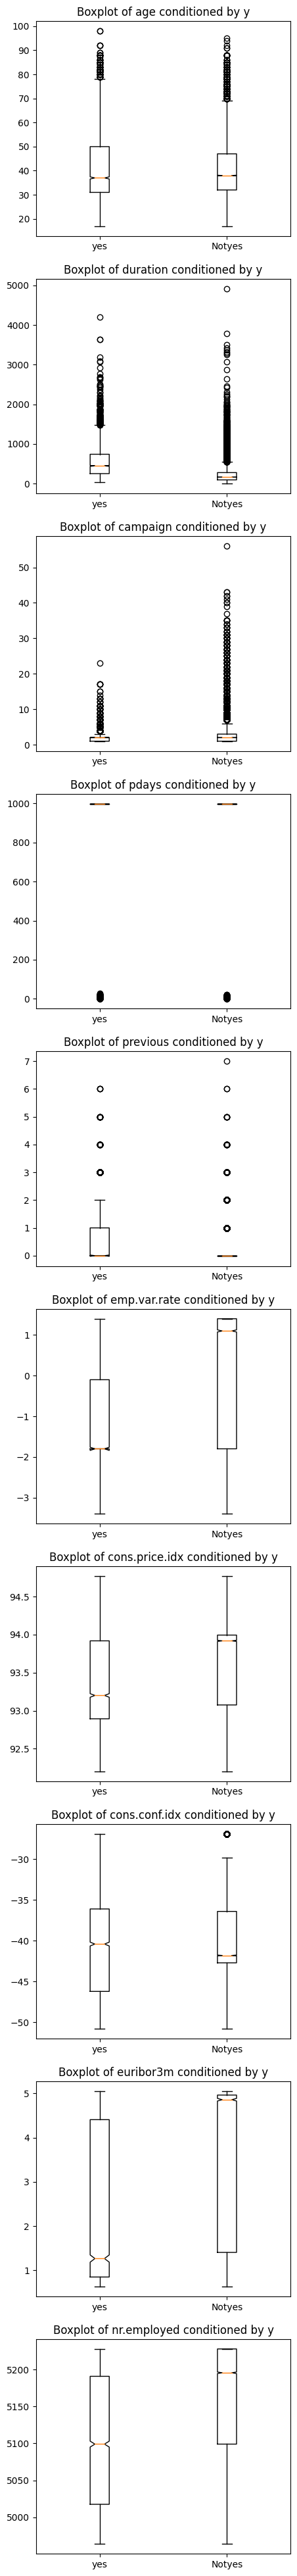

In [12]:
#df=process.remove_outliers(df)
fig,axs=plt.subplots(nrows=len(quantitatives),figsize=(5,len(quantitatives)*5))
for i in range(len(quantitatives)):
    analyzer.prop_churn_by_numerical_boxplot(df,outcome,positive_mod,quantitatives[i],axs[i])

'age': a little, little bit influence, distributions seems same (*)
'duration': influence, different median for distributions
'campaign': influence, different median for distributions
'pdays': influence:pdays is special, because when pdays=999, client didn't participate at previous campaign, but 999 is an outlier of pdays
'previous': influence: previous is special feature, a boxplot without outliers is not relevant because after removing features, "previous" become constant
'emp.var.rate': influence, different median for distributions
'cons.price.idx': a little bit influence, medians are equivalent (~93 to ~94 for this two medians)
'cons.conf.idx': a little bit influence, quantiles 75% seems be same, but quantile 25% are different (*)
'euribor3m': influence, different median for distributions
'nr.employed': influence, different median for distributions

Conclusion -relevant quantitative features:
duration, campaign, previous, pdays, emp.var.rate, euribor3m, nr.employed

In [13]:
relevant_features_quanti=[
    "duration",
    "campaign",
    "previous",
    "pdays",
    "emp.var.rate",
    "euribor3m",
    "nr.employed"
]
relevant_features_quali=[
    'job',
    'default',
    'contact',
    'month',
    'poutcome'
]
#we decided to remove 'poutcome' because when we removed outliers, this feature become constant
relevant_features=relevant_features_quanti+relevant_features_quali
df_new=df[[outcome]+relevant_features] #we decided to work with only relevant features for Attrition

<Axes: >

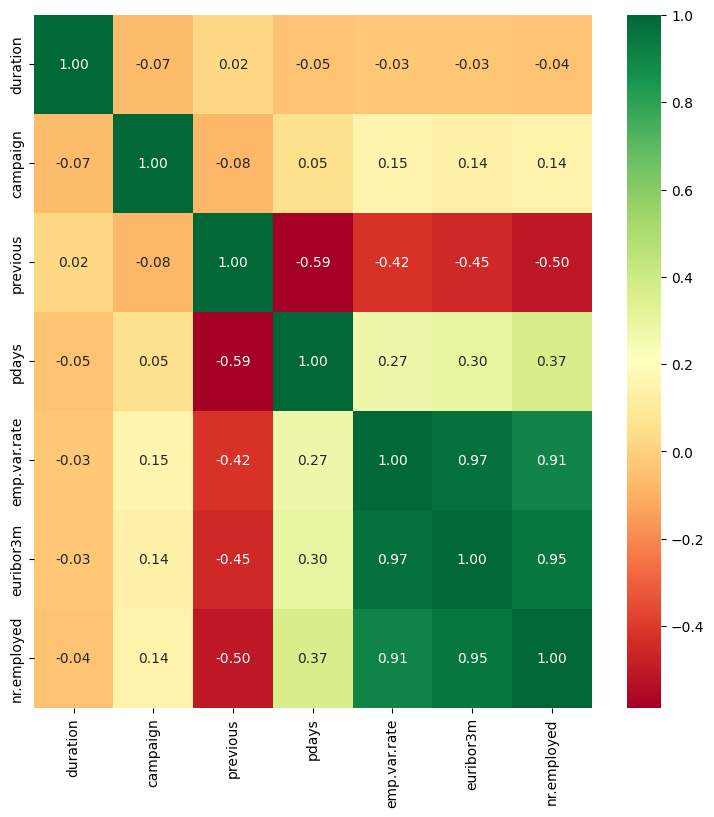

In [14]:
plt.figure(figsize=(9,9))
analyzer.correlation_heatmap(df_new,annot=True)

In [15]:
correlations=df_new.corr(numeric_only=True)
groups={1:.3,2:.6,3:.6}
"""
high correlation (>=.6): group3
medium correlation (>=.3 and <.6): group2
low correlation (<.3):group1
"""
print()

In [16]:
dict_correlations={key:[] for key in groups.keys()}
rows = cols = None

for group in groups.keys():
    if group==1:
        rows, cols =np.where(np.abs(correlations) < groups[group])
    elif group==2:
        rows, cols =np.where((np.abs(correlations) < groups[group]) & (np.abs(correlations) >= groups[group-1]))
    elif group==3:
        rows, cols =np.where(np.abs(correlations) >= groups[group])
    dict_correlations[group]=[(correlations.index[row], correlations.columns[col], correlations.iloc[row, col]) \
                              for row, col in zip(rows, cols) if row != col]

In [17]:
{
    group_number: dict_correlations[group_number]
        for group_number in dict_correlations.keys()
}

{1: [('duration', 'campaign', -0.07169922626415286),
  ('duration', 'previous', 0.020640350701749542),
  ('duration', 'pdays', -0.047577015445611645),
  ('duration', 'emp.var.rate', -0.027967884489332732),
  ('duration', 'euribor3m', -0.03289665570187456),
  ('duration', 'nr.employed', -0.04470322316242443),
  ('campaign', 'duration', -0.07169922626415286),
  ('campaign', 'previous', -0.07914147244884367),
  ('campaign', 'pdays', 0.052583573385024604),
  ('campaign', 'emp.var.rate', 0.15075380555787),
  ('campaign', 'euribor3m', 0.13513251080435595),
  ('campaign', 'nr.employed', 0.1440948948447463),
  ('previous', 'duration', 0.020640350701749542),
  ('previous', 'campaign', -0.07914147244884367),
  ('pdays', 'duration', -0.047577015445611645),
  ('pdays', 'campaign', 0.052583573385024604),
  ('pdays', 'emp.var.rate', 0.2710041742618581),
  ('pdays', 'euribor3m', 0.2968991123969819),
  ('emp.var.rate', 'duration', -0.027967884489332732),
  ('emp.var.rate', 'campaign', 0.15075380555787

We can see that 'emp.var.rate' and 'euribor3m' have very high correlations (~0.97)
'emp.var.rate' and 'nr.employed' have a correlation with .906 in absolute value.
We remove 'emp.var.rate', 'nr.employed' before training ML models

In [18]:
removed_features=["emp.var.rate","nr.employed"]
relevant_features=[f for f in relevant_features if f not in removed_features]
df_new_=df_new[[outcome]+relevant_features]

In [19]:
process.summary(df_new_)

{'Missing Values': y            0
 duration     0
 campaign     0
 previous     0
 pdays        0
 euribor3m    0
 job          0
 default      0
 contact      0
 month        0
 poutcome     0
 dtype: int64,
 'Constant Features': []}

In [20]:
analyzer.summary(df_new_)

{'features': {'qualitative_columns': ['y',
   'job',
   'default',
   'contact',
   'month',
   'poutcome'],
  'quantitative_columns': ['duration',
   'campaign',
   'previous',
   'pdays',
   'euribor3m']},
 'describe':            duration      campaign      previous         pdays     euribor3m
 count  41188.000000  41188.000000  41188.000000  41188.000000  41188.000000
 mean     258.285010      2.567593      0.172963    962.475454      3.621291
 std      259.279249      2.770014      0.494901    186.910907      1.734447
 min        0.000000      1.000000      0.000000      0.000000      0.634000
 25%      102.000000      1.000000      0.000000    999.000000      1.344000
 50%      180.000000      2.000000      0.000000    999.000000      4.857000
 75%      319.000000      3.000000      0.000000    999.000000      4.961000
 max     4918.000000     56.000000      7.000000    999.000000      5.045000}

In [21]:
###END OF SESSION 1

In [21]:
from src.core.ComputeModel import ComputeModel
from src.core.globals import MODEL_HYPERPARAMETERS_DEF
import copy

positive_mod="yes"
models={"Logistic Regression":None,
        "SVM":None,
        "DecisionTreeClassifier":None
        }

In [21]:
#we use liblinear solver because Gradient descent doesn't converge for Logistic Regression
for model_name in models.keys():
    if model_name == "Logistic Regression":
        hyperparameters=copy.deepcopy(MODEL_HYPERPARAMETERS_DEF[model_name])
        hyperparameters["solver"]="liblinear"
    else:
        hyperparameters=None
    models[model_name]=ComputeModel(
        df_new_[relevant_features],df_new_[outcome],
        process=process,model_name=model_name,
        hyperparameters=hyperparameters,positive_mod=positive_mod
    )
    models[model_name].fit()

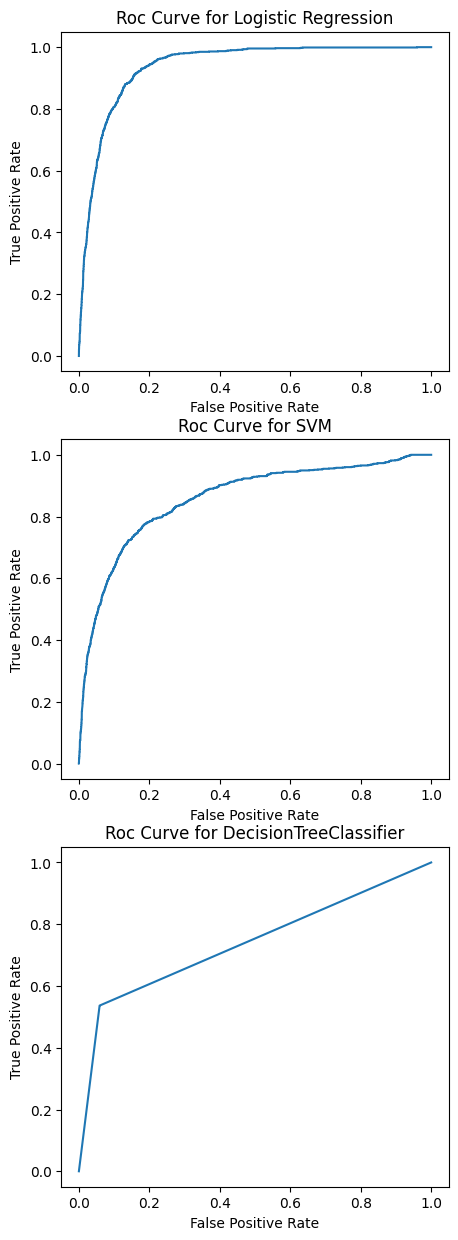

In [22]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_default={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}

In [23]:
metrics_default

{'Logistic Regression': {'auc': 0.9384230977876314,
  'accuracy': 0.9122359796067007,
  'precision': 0.6814159292035398,
  'recall': 0.41487068965517243,
  'f1_score': 0.5157401205626256},
 'SVM': {'auc': 0.8580964904004905,
  'accuracy': 0.8976693372177713,
  'precision': 0.5529265255292652,
  'recall': 0.47844827586206895,
  'f1_score': 0.512998266897747},
 'DecisionTreeClassifier': {'auc': 0.7388755070993915,
  'accuracy': 0.8956057295460063,
  'precision': 0.5366379310344828,
  'recall': 0.5366379310344828,
  'f1_score': 0.5366379310344828}}

In conclusion:
we set up three models, DecisionTreeClassifier, SVM, Logistic Regression:
we use AUC metrics because it's metrics that allow to see False positive Rate and True Positive Rate, and as dataset is imbalanced, accuracy in this case is not relevant
- We can see that  Logistic Regression and SVM  are the best model because auc ~ 0.93 and auc ~0.85 respectively for Logistic Regression and SVM:
  roc curve for 2 models are really good two concave curve with very high auc
- Decision Tree Classifier have 0.738 auc but f1-score are better than 2 others models.
- Simplify conclusion: Logistic Regression > SVM > DecisionTreeClassifier (with default hyperparameters)

In [24]:
distributions_test={model_name:None for model_name in models.keys()}
for model_name in models.keys():
    X_test=models[model_name].dict_split["arrays"]["X_test"]
    distributions_test[model_name]=models[model_name].model.predict_proba(X_test)
distributions_test

{'Logistic Regression': array([0.0190313 , 0.16489171, 0.23204396, ..., 0.41676087, 0.0412618 ,
        0.01898637]),
 'SVM': array([0.04090164, 0.09366673, 0.11193888, ..., 0.13452255, 0.08761918,
        0.01591402]),
 'DecisionTreeClassifier': array([0., 0., 0., ..., 1., 0., 0.])}

In [38]:
params_grid= \
    {
        "Logistic Regression": \
            {
                "penalty": ["l2"],
                "C": np.logspace(-3, 3, 7),
                "solver": ["liblinear"],
                "multi_class": ["auto"],
                "n_jobs": [None],
                "max_iter": [650,750]
            },
        "SVM":
            {
                "kernel": ["linear"],
                "C": [1,.1,.01],
                "degree": [3],
                "gamma": [1,.01,.001]

            },
        "DecisionTreeClassifier":
            {
                "criterion": ["gini"],
                "splitter": ["best"],
                "max_depth": [None],
                "min_samples_split": [2, 3, 4],
                "min_samples_leaf": [1],
                "min_weight_fraction_leaf": [0.],
                "max_features": [None],
                "random_state": [None],
                "max_leaf_nodes": [None]+list(range(2, 100)),
                "min_impurity_decrease": [0.],
                "class_weight": [None],
                "ccp_alpha": [0.]
            }
    }

In [26]:
def simulation(df_new_=df_new_,relevant_features=relevant_features,outcome=outcome,model_names=list(models.keys()),positive_mod=positive_mod,params_grid=params_grid,cv=3):
    models={model_name:{} for model_name in model_names}
    for model_name in model_names:
        for k in [0,5]:
            model=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                               process=process,model_name=model_name, \
                               positive_mod=positive_mod,grid_search=True,cv=cv,params_grid=params_grid[model_name])
            model.fit(random_state=k)
            models[model_name][k]=model
    return models

In [27]:
def results(models_dict):
    return pd.DataFrame({k:model.metrics() for k,model in zip(models_dict.keys(),models_dict.values())})

In [28]:
models_types=simulation()

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 297 candidates, totalling 891 fits
Fitting 3 folds for each of 297 candidates, totalling 891 fits


In [29]:
metrics_all_models={model_name:results(models_types[model_name]) for model_name in models_types.keys()}

In [51]:
for model_name in models_types.keys():
    print(f"{model_name}:")
    print(metrics_all_models[model_name])
    print("\n")

Logistic Regression:
                  0         5
auc        0.930900  0.932190
accuracy   0.907745  0.911629
precision  0.647368  0.686567
recall     0.397629  0.396552
f1_score   0.492657  0.502732


SVM:
                  0         5
auc        0.888488  0.889866
accuracy   0.904346  0.907259
precision  0.603245  0.636213
recall     0.440733  0.412716
f1_score   0.509340  0.500654


DecisionTreeClassifier:
                  0         5
auc        0.930864  0.929309
accuracy   0.914421  0.917213
precision  0.622125  0.674221
recall     0.612069  0.512931
f1_score   0.617056  0.582619




we can observe that Logistic Regression have a good AUC (0.930) ,DecisionTreeClassifier (0.931) and SVM (0.889) also with cross validation.
f1 score is low in 3 model (0.5 to 0.6) because the dataset is imbalanced and during sequence 4, we wiil do oversampling/under sampling to equilibrate the dataset.
Conclusion: with tuning and cross validation, metrics (auc) increase globally in 3 models. furthermore results are reliable with cross validation.
But a problem of imbalanced dataset is not resolved and during sequence 4, we are going do a over/under sampling to equilibrate dataset.
the best model of 3 is DecisionTreeClassifier because he has a best AUC (with Logistic Regression) with cross validation and other metrics are best also, precisely precision and recall, f1 score are high (~0.61) for an imbalanced dataset

In [31]:
best_model=models_types["DecisionTreeClassifier"][0]
hyperparameters=best_model.model.hyperparameters

In [32]:
###END OF SESSION 2

In [52]:
#increase number of cross validation
model_gradient=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                            process=process,model_name="GradientBoostingClassifier", \
                            positive_mod=positive_mod,grid_search=True,cv=3)
model_gradient.fit()

Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [53]:
model_gradient.metrics()

{'auc': 0.9532831000283032,
 'accuracy': 0.9243748482641417,
 'precision': 0.7074829931972789,
 'recall': 0.5603448275862069,
 'f1_score': 0.6253758268190018}

We can see that auc is very good and accuracy as well, we need to balanced the dataset to improve f1-score (precision,recall also because
the model have bias for majority class for outcome ("y" variable). I think the dataset is too imbalanced.

In [54]:
model_random=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                          process=process,model_name="RandomForestClassifier", \
                          positive_mod=positive_mod,grid_search=True)
model_random.fit()

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [55]:
model_random.metrics()

{'auc': 0.9507194472616634,
 'accuracy': 0.9215829084729303,
 'precision': 0.7098214285714286,
 'recall': 0.5140086206896551,
 'f1_score': 0.5962500000000001}

We can see that auc is very good and accuracy as well, we need to balanced the dataset to improve f1-score (precision,recall also because
the model have bias for majority class for outcome ("y" variable). I think the dataset is too imbalanced.
The best model is Gradient Boosting

In [56]:
best_model=model_gradient.model.model
hyperparameters_best=model_gradient.model.hyperparameters

In [57]:
hyperparameters_best

{'learning_rate': 0.05, 'n_estimators': 500}

In [58]:
best_model

GradientBoostingClassifier(learning_rate=0.05, n_estimators=500)

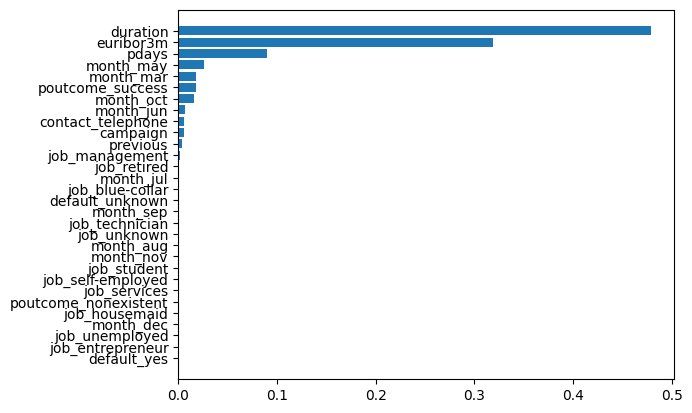

In [59]:
importances=best_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(model_random.dict_split["columns_features"])[indices])

In [61]:
model_gradient.dict_split["columns_features"]

Index(['job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'default_unknown', 'default_yes', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_nonexistent',
       'poutcome_success', 'duration', 'campaign', 'previous', 'pdays',
       'euribor3m'],
      dtype='object')

We can see that "duration", "euribor3m", "pdays" are top 3 of most influent features for GradientBoostingClassifier

In [62]:
relevant_features_top3=["duration","euribor3m","pdays"]
model_top3=ComputeModel(df_new_[relevant_features_top3],df_new_[outcome], \
                        process=process,model_name="GradientBoostingClassifier", \
                        positive_mod=positive_mod,hyperparameters=hyperparameters_best)

In [63]:
model_top3.fit()

In [64]:
model_top3.metrics()

{'auc': 0.9481126025991792,
 'accuracy': 0.9221898519058024,
 'precision': 0.7041251778093883,
 'recall': 0.5334051724137931,
 'f1_score': 0.6069895769466584}

We can see with a evaluation with a test set, metrics for the 3 most influent features stay at the same order of values comparison to full model with all relevant features. Model is more simple with only 3 features and the metrics evaluation are very good.

In [65]:
relevant_features_bad3=["job","default","poutcome"]
model_bad3=ComputeModel(df_new_[relevant_features_bad3],df_new_[outcome], \
                        process=process,model_name="GradientBoostingClassifier", \
                        positive_mod=positive_mod,hyperparameters=hyperparameters_best)

In [66]:
model_bad3.fit()

In [67]:
model_bad3.metrics()

{'auc': 0.6849956808104156,
 'accuracy': 0.8970623937848993,
 'precision': 0.65748031496063,
 'recall': 0.17995689655172414,
 'f1_score': 0.28257191201353643}

We can see a coherence, the 3 most influent features for GradientBoostingClassifier give a good model with high score (auc~ 0.948, accuracy~0.92)
and with the 3 less influent features, model give a metrics that it is smaller than model with 3 most influent features.
Furthermore, with model_top3, we simplify the model (decrease number of features). And metrics with 3 most influent features and model with
full relevant features are almost same in term of metrics evaluation.

In [68]:
relevant_features_top3=relevant_features_top3
model_seq3=model_top3

In [69]:
hyperparameters_best

{'learning_rate': 0.05, 'n_estimators': 500}

In [70]:
model_seq3

In [49]:
###END OF SESSION 3

In [28]:
models={"Logistic Regression":None,
        "SVM":None,
        "DecisionTreeClassifier":None,
        "RandomForestClassifier": None,
        "GradientBoostingClassifier":None
        }

In [29]:
df_new_[[e for e in relevant_features if e in quantitatives]]=process.standard_scaler(df_new_[[e for e in relevant_features if e in quantitatives]])

/tmp/ipykernel_111710/4022361902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_[[e for e in relevant_features if e in quantitatives]]=process.standard_scaler(df_new_[[e for e in relevant_features if e in quantitatives]])


In [30]:
import copy
#we use liblinear solver because Gradient descent doesn't converge for Logistic Regression
for model_name in models.keys():
    if model_name == "Logistic Regression":
        hyperparameters=copy.deepcopy(MODEL_HYPERPARAMETERS_DEF[model_name])
        hyperparameters["solver"]="liblinear"
    else:
        hyperparameters=None
    models[model_name]=ComputeModel(
        df_new_[relevant_features],df_new_[outcome],
        process=process,model_name=model_name,
        hyperparameters=hyperparameters,positive_mod=positive_mod
    )
    models[model_name].fit()

{'Logistic Regression': {'auc': 0.9389878355111092,
  'accuracy': 0.9130857004127215,
  'precision': 0.6906474820143885,
  'recall': 0.41379310344827586,
  'f1_score': 0.5175202156334232},
 'SVM': {'auc': 0.937779936553611,
  'accuracy': 0.9031318281136198,
  'precision': 0.6577669902912622,
  'recall': 0.2920258620689655,
  'f1_score': 0.4044776119402985},
 'DecisionTreeClassifier': {'auc': 0.7385303404641729,
  'accuracy': 0.8942704539936878,
  'precision': 0.5302869287991498,
  'recall': 0.5377155172413793,
  'f1_score': 0.5339753879079722},
 'RandomForestClassifier': {'auc': 0.9415244380631161,
  'accuracy': 0.9195193008011653,
  'precision': 0.6687898089171974,
  'recall': 0.5657327586206896,
  'f1_score': 0.6129597197898423},
 'GradientBoostingClassifier': {'auc': 0.9511906516816832,
  'accuracy': 0.9223112405923768,
  'precision': 0.6988950276243094,
  'recall': 0.5452586206896551,
  'f1_score': 0.612590799031477}}

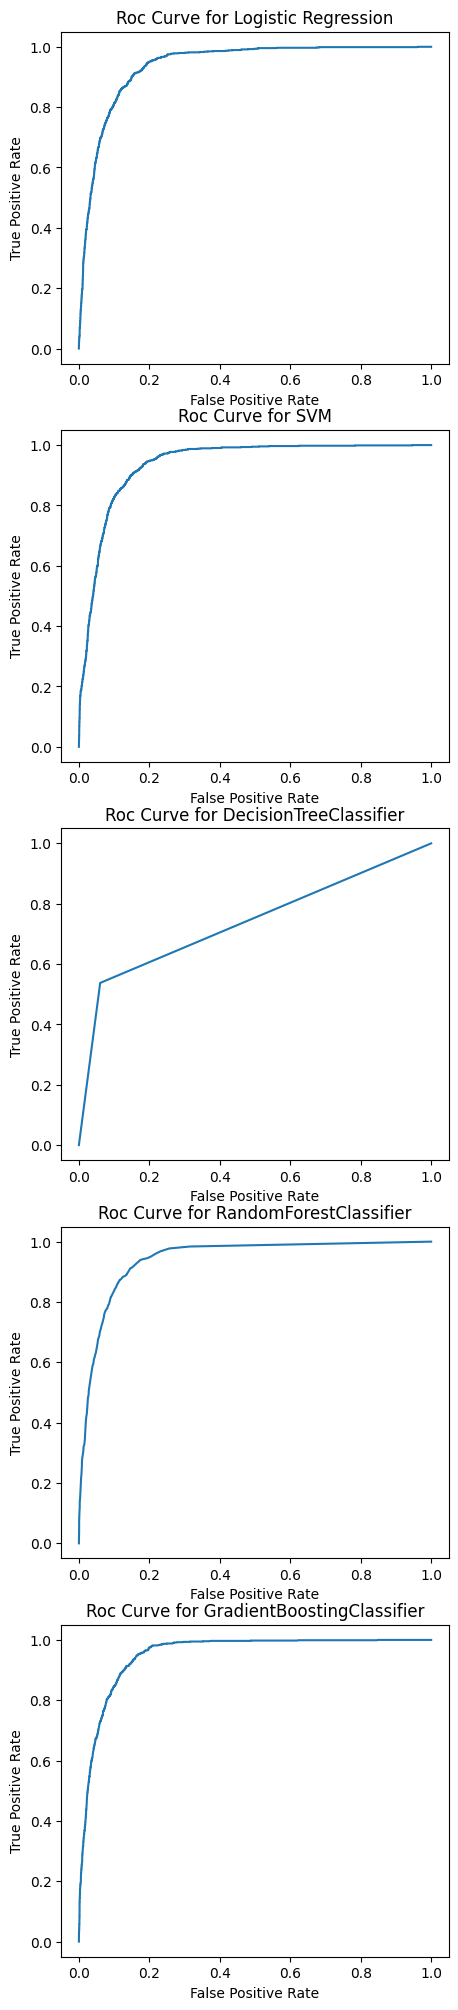

In [31]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_default={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}
metrics_default

In [32]:
#we use liblinear solver because Gradient descent doesn't converge for Logistic Regression
for model_name in models.keys():
    if model_name == "Logistic Regression":
        hyperparameters=copy.deepcopy(MODEL_HYPERPARAMETERS_DEF[model_name])
        hyperparameters["solver"]="liblinear"
    else:
        hyperparameters=None
    models[model_name]=ComputeModel(
        df_new_[relevant_features],df_new_[outcome],
        process=process,model_name=model_name,
        hyperparameters=hyperparameters,positive_mod=positive_mod
    )
    models[model_name].fit(sampling=True,method="SMOTE")

{'Logistic Regression': {'auc': 0.9386995963403018,
  'accuracy': 0.8755813953488372,
  'precision': 0.8668002672010688,
  'recall': 0.8875512995896033,
  'f1_score': 0.8770530584656979},
 'SVM': {'auc': 0.9377992780161726,
  'accuracy': 0.8778385772913817,
  'precision': 0.8511314518179507,
  'recall': 0.9158686730506156,
  'f1_score': 0.88231418028466},
 'DecisionTreeClassifier': {'auc': 0.9204980715284238,
  'accuracy': 0.9203830369357046,
  'precision': 0.9185508035957505,
  'recall': 0.9225718194254446,
  'f1_score': 0.9205569205569206},
 'RandomForestClassifier': {'auc': 0.9891794030627235,
  'accuracy': 0.94890560875513,
  'precision': 0.9330869737363072,
  'recall': 0.9671682626538988,
  'f1_score': 0.949821992342312},
 'GradientBoostingClassifier': {'auc': 0.9710178512279152,
  'accuracy': 0.9097127222982216,
  'precision': 0.8804623983739838,
  'recall': 0.9481532147742818,
  'f1_score': 0.9130549334738506}}

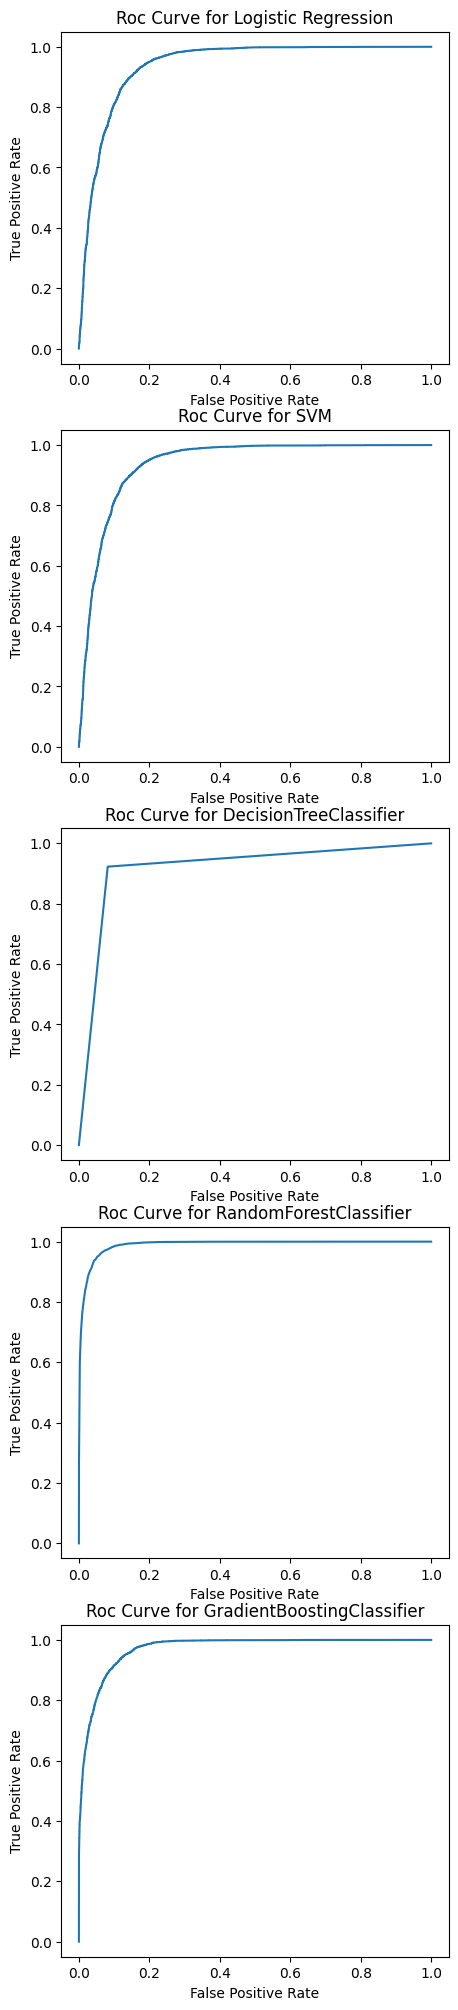

In [33]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_default_b={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}
metrics_default_b

We can see with default hyperparameters that with oversampling, metrics of models improve significantly, precisely precision, recall and f1-score increase (~0.9 for all models). Means that oversampling works and models don't have a bias for majority class and can predict minority class frequently (that's why precision, recall, f1-score increase).
The best model with default hyperparameter is RandomForestCLassifier (0.989 for auc, 0.967 for recall etc..).The roc curve have a beautiful curve (concave curve) But to have a relevant conclusion, we need to find the best model with a grid search and cross validation. Because even if the metrics are high for the model, there is one test set and one training set and so even if the bias of the model is small but variance can be high and consequently, the predictions for the model can have a variability with the training set (overfitting)

In [35]:
#we use liblinear solver because Gradient descent doesn't converge for Logistic Regression
for model_name in models.keys():
    if model_name == "Logistic Regression":
        hyperparameters=copy.deepcopy(MODEL_HYPERPARAMETERS_DEF[model_name])
        hyperparameters["solver"]="liblinear"
    else:
        hyperparameters=None
    models[model_name]=ComputeModel(
        df_new_[relevant_features],df_new_[outcome],
        process=process,model_name=model_name,
        hyperparameters=hyperparameters,positive_mod=positive_mod
    )
    models[model_name].fit(sampling=True,method="RandomUnderSampling")

{'Logistic Regression': {'auc': 0.9382431629013079,
  'accuracy': 0.8609913793103449,
  'precision': 0.8112773302646721,
  'recall': 0.759698275862069,
  'f1_score': 0.7846410684474124},
 'SVM': {'auc': 0.9372384414945005,
  'accuracy': 0.8685344827586207,
  'precision': 0.7983014861995754,
  'recall': 0.8103448275862069,
  'f1_score': 0.8042780748663101},
 'DecisionTreeClassifier': {'auc': 0.8169496878715814,
  'accuracy': 0.8390804597701149,
  'precision': 0.7637362637362637,
  'recall': 0.7489224137931034,
  'f1_score': 0.7562568008705113},
 'RandomForestClassifier': {'auc': 0.9424780302467299,
  'accuracy': 0.8703304597701149,
  'precision': 0.786074672048436,
  'recall': 0.8394396551724138,
  'f1_score': 0.8118811881188119},
 'GradientBoostingClassifier': {'auc': 0.947089704406956,
  'accuracy': 0.8753591954022989,
  'precision': 0.7955239064089522,
  'recall': 0.8426724137931034,
  'f1_score': 0.8184196755625326}}

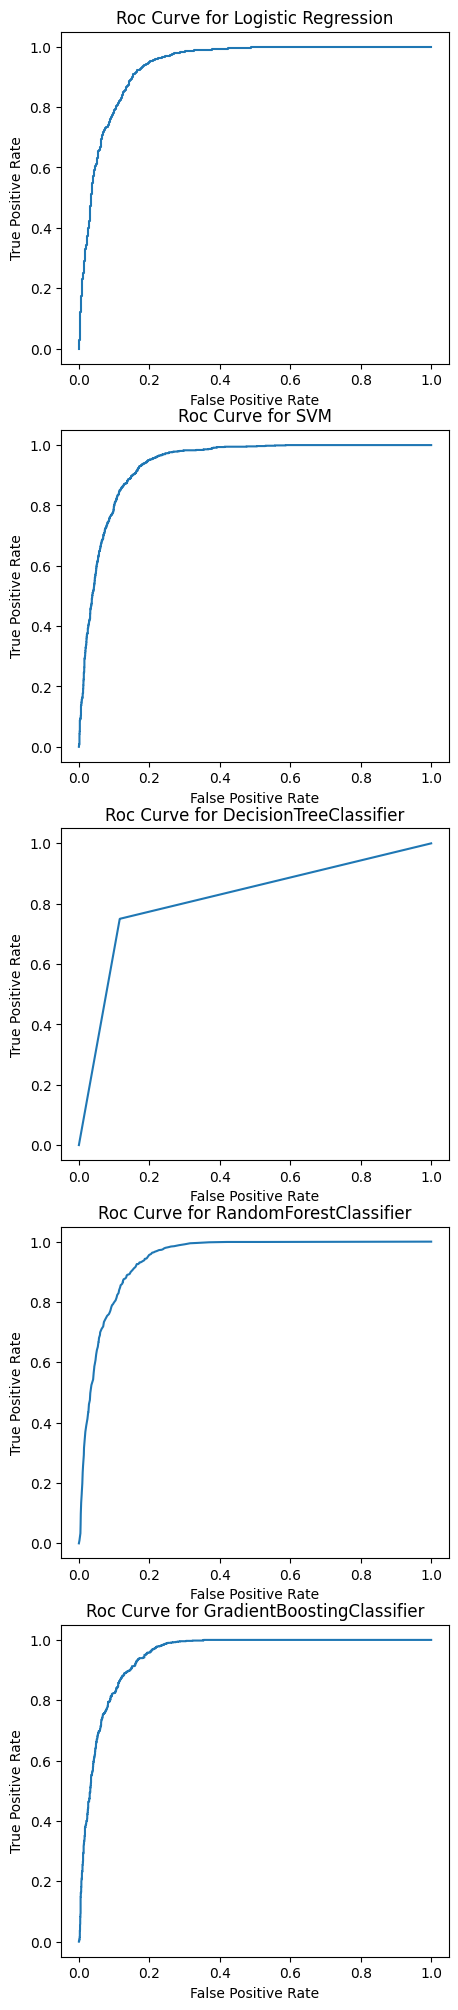

In [36]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_default_bunder={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}
metrics_default_bunder

Same conclusion that for oversampling, metrics increase but metrics increase less than metrics for oversampling because I think the number of rows of this dataset with unersampling is small.
So models don't have a lot of informations to recognize a pattern or something like that to predict minority or majority class.
GradientBoostingClassifier seems the best model.
We are going to do a cross validation with grid search to find the best model for this dataset.

In [40]:
params_grid= \
    {
        "Logistic Regression": \
            {
                "penalty": ["l2"],
                "C": np.logspace(-3, 3, 7),
                "solver": ["liblinear"],
                "multi_class": ["auto"],
                "n_jobs": [None],
                "max_iter": [650,750]
            },
        "SVM":
            {
                "kernel": ["linear"],
                "C": [1,.1,.01],
                "degree": [3],
                "gamma": [1,.01,.001]

            },
        "DecisionTreeClassifier":
            {
                "criterion": ["gini"],
                "splitter": ["best"],
                "max_depth": [None],
                "min_samples_split": [2, 3, 4],
                "min_samples_leaf": [1],
                "min_weight_fraction_leaf": [0.],
                "max_features": [None],
                "random_state": [None],
                "max_leaf_nodes": [None]+list(range(2, 100)),
                "min_impurity_decrease": [0.],
                "class_weight": [None],
                "ccp_alpha": [0.]
            },
        "RandomForestClassifier":
            {
                "n_estimators":list(np.random.randint(50,500,size=5)),
                "max_depth":list(np.random.randint(1,20,size=5))
            },
        "GradientBoostingClassifier":
            {
                "learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001],
                "n_estimators":[100,250,500,750,1000,1250,1500,1750]
            }
    }

In [41]:
#we used 3 fold cross validation with a params default grid located in globals file (in src directory)
for model_name in models.keys():
    models[model_name]=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                                    process=process,model_name=model_name, \
                                    positive_mod=positive_mod,grid_search=True,cv=3,params_grid=params_grid[model_name],stratify=False)
    models[model_name].fit(sampling=True,method="SMOTE") # strategy for oversampling: "auto"

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 297 candidates, totalling 891 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits


{'Logistic Regression': {'auc': 0.94035915109503,
  'accuracy': 0.8796853625170998,
  'precision': 0.8637978681405448,
  'recall': 0.9006586169045006,
  'f1_score': 0.8818432189158326},
 'SVM': {'auc': 0.9408252072924546,
  'accuracy': 0.8815321477428181,
  'precision': 0.8531655225019069,
  'recall': 0.9208287596048299,
  'f1_score': 0.8857067440939685},
 'DecisionTreeClassifier': {'auc': 0.9169500825067686,
  'accuracy': 0.9168262653898769,
  'precision': 0.9153214774281806,
  'recall': 0.9180845225027442,
  'f1_score': 0.9167009179339636},
 'RandomForestClassifier': {'auc': 0.9813626645569128,
  'accuracy': 0.9309165526675787,
  'precision': 0.8966388678291635,
  'recall': 0.973655323819978,
  'f1_score': 0.9335613735034863},
 'GradientBoostingClassifier': {'auc': 0.9902685504739012,
  'accuracy': 0.944733242134063,
  'precision': 0.9408163265306122,
  'recall': 0.9488199780461032,
  'f1_score': 0.9448012023500478}}

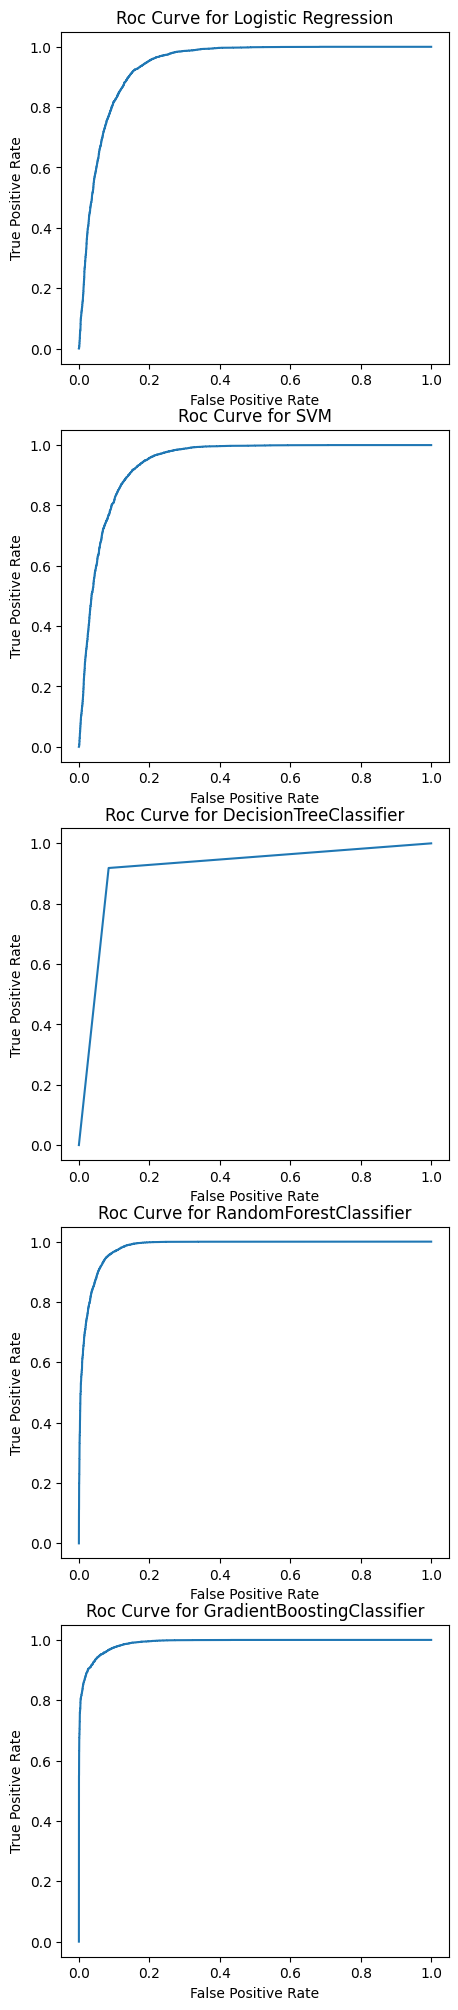

In [42]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_b={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}
metrics_b

With cross validation (3 fold) and grid search, we have a powerfull models. the metrics for models are high with cross validation ! implies that bias and variance are small, that's very good, we
have a certain level of confidence for our predictions.
The best model with the best AUC is GradientBoostingClassifier with tuning of hyperparameters. (AUC ~ 0.99, f1-score ~0.944), the roc curve is very good and we have reduced ther risk of overfitting with our cross validation.
But others models can be fine, for example: RandomForestClassifier or DecisionTreeClassifier are good also.
Best model with oversampling: GradientBoostingClassifier with tuning of hyperparameters.


In [43]:
{key:model.model.hyperparameters for key,model in zip(models.keys(),models.values())}

{'Logistic Regression': {'C': 0.01,
  'max_iter': 650,
  'multi_class': 'auto',
  'n_jobs': None,
  'penalty': 'l2',
  'solver': 'liblinear'},
 'SVM': {'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'linear'},
 'DecisionTreeClassifier': {'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'random_state': None,
  'splitter': 'best'},
 'RandomForestClassifier': {'max_depth': 17, 'n_estimators': 281},
 'GradientBoostingClassifier': {'learning_rate': 0.15, 'n_estimators': 1750}}

In [44]:
#we used 3 fold cross validation with a params default grid located in globals file (in src directory)
for model_name in models.keys():
    models[model_name]=ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                                    process=process,model_name=model_name, \
                                    positive_mod=positive_mod,grid_search=True,cv=3,params_grid=params_grid[model_name],stratify=False)
    models[model_name].fit(sampling=True,method="RandomUnderSampling") #strategy : Number_of_minority_class = .5 * Number_of_majority_class

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 297 candidates, totalling 891 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits


{'Logistic Regression': {'auc': 0.9321418403933082,
  'accuracy': 0.8663793103448276,
  'precision': 0.8072009291521487,
  'recall': 0.7713651498335183,
  'f1_score': 0.7888762769580023},
 'SVM': {'auc': 0.9335700051220599,
  'accuracy': 0.8663793103448276,
  'precision': 0.7828877005347593,
  'recall': 0.8124306326304107,
  'f1_score': 0.7973856209150327},
 'DecisionTreeClassifier': {'auc': 0.9292586923245134,
  'accuracy': 0.8638649425287356,
  'precision': 0.7509615384615385,
  'recall': 0.8668146503884573,
  'f1_score': 0.8047398248325606},
 'RandomForestClassifier': {'auc': 0.9518726758431506,
  'accuracy': 0.8857758620689655,
  'precision': 0.8078141499472017,
  'recall': 0.8490566037735849,
  'f1_score': 0.8279220779220778},
 'GradientBoostingClassifier': {'auc': 0.948440777727939,
  'accuracy': 0.8814655172413793,
  'precision': 0.8053475935828877,
  'recall': 0.8357380688124306,
  'f1_score': 0.8202614379084967}}

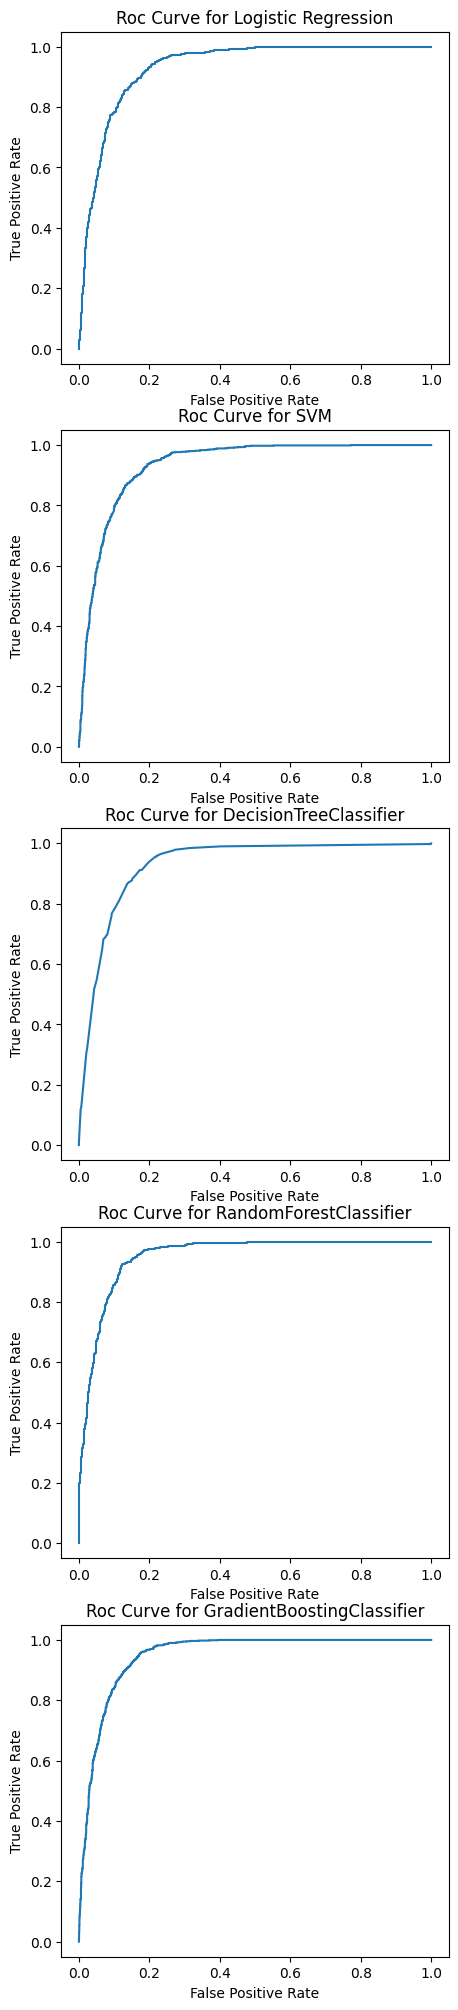

In [45]:
fig,axs=plt.subplots(nrows=len(models.keys()),figsize=(5,5*len(models.keys())))
metrics_bunder={list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))}
metrics_bunder

Same conclusion that for oversampling:
models have a very good metrics and very good roc curve with cross validation. So models learn how detect majority class and minority class for under/oversampling both. Oversampling/ Undersampling allows to help model to predict minority class and to reduce bias for majority class for models. But with Undersampling, metrics are good but less than metrics for oversampling. Meaning that with undersampling models have less information/data than for oversampling and consequently models "learn" less how to detect majority class /minority class
Best model with undersampling: RandomForestClassifier with tuning of hyperparameters.

In [46]:
{key:model.model.hyperparameters for key,model in zip(models.keys(),models.values())}

{'Logistic Regression': {'C': 0.09999999999999999,
  'max_iter': 650,
  'multi_class': 'auto',
  'n_jobs': None,
  'penalty': 'l2',
  'solver': 'liblinear'},
 'SVM': {'C': 0.01, 'degree': 3, 'gamma': 1, 'kernel': 'linear'},
 'DecisionTreeClassifier': {'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': 42,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'random_state': None,
  'splitter': 'best'},
 'RandomForestClassifier': {'max_depth': 12, 'n_estimators': 484},
 'GradientBoostingClassifier': {'learning_rate': 0.1, 'n_estimators': 250}}

In [23]:
hyperparams_opti={
    "GradientBoostingClassifier":
        {
            "learning_rate":0.1,
            "n_estimators":250
        },
    "RandomForestClassifier":
        {
            "max_depth": 12,
            "n_estimators": 484
        }

}
#To conclude, this 2 models are the best for this dataset, we choose the model with a model with fewer parameters to reduce variance of the model.
#GradientBoostingClassifier have few estimators than "RandomForestClassifier", we choose it.

In [92]:
from src.core.ComputeModel import ComputeModel
best_models={
    "GradientBoostingClassifier":
        ComputeModel(df_new_[relevant_features],df_new_[outcome], \
                     process=process,model_name="GradientBoostingClassifier", \
                     positive_mod=positive_mod,grid_search=False,params_grid=hyperparams_opti["GradientBoostingClassifier"],stratify=False)
}

In [93]:
p=.15
best_models["GradientBoostingClassifier"].fit(sampling=True,method="SMOTE",perc_minority=p)
while best_models["GradientBoostingClassifier"].metrics()["f1_score"] < .901:
    best_models["GradientBoostingClassifier"].fit(sampling=True,method="SMOTE",perc_minority=p)
    p+=.1

In [94]:
"Percentage of minority class: " + str(round((p/(p+1))*100,2)) +"%" #39% percentage of minority class with oversampling for f1_score >=0.901

'Percentage of minority class: 39.39%'

{'auc': 0.9847604077002445,
 'accuracy': 0.9325684024713151,
 'precision': 0.9035907525823905,
 'recall': 0.9080573405832921,
 'f1_score': 0.9058185404339251}

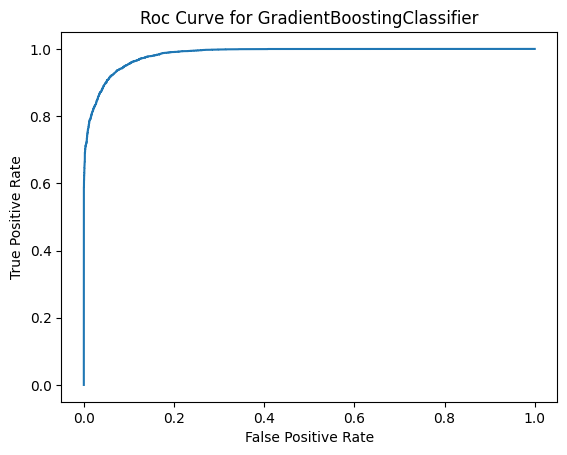

In [97]:
fig,ax=plt.subplots()
best_models["GradientBoostingClassifier"].metrics(plot_roc=True,ax=ax)

In [102]:
bias_two,variance=best_models["GradientBoostingClassifier"].bias_variance_estimate(bootstrap_rounds=301)

/home/khaldi/Documents/unbalanced-data-ml/src/core/ComputeModel.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/khaldi/Documents/unbalanced-data-ml/src/core/ComputeModel.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/khaldi/Documents/unbalanced-data-ml/src/core/ComputeModel.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

In [103]:
print(f"Finally: Bias²: {bias_two} and Variance: {variance}")

Finally: Bias²: 0.06005471956224351 and Variance: 0.00911462475742055
